# GitHub Ecosystem Mapping

In this notebook we will explore the Augur GitHub data to generate an ecosystem mapping of open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Respositories

In [3]:
aval_repos = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived,
                b.repo_git
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id
            ORDER BY
                rg_name,
                repo_name;
    """)
aval_repos = pd.read_sql(repo_query, con=engine)
display(aval_repos)
aval_repos.dtypes

rg_name  repo_group_id                       repo_name  repo_id  \
0        3scale          25556                          3scale    33134   
1        3scale          25556  3scale-amp-openshift-templates    33126   
2        3scale          25556               3scale-api-python    33130   
3        3scale          25556                 3scale-api-ruby    33158   
4        3scale          25556                3scale-go-client    33169   
...         ...            ...                             ...      ...   
10956  zerodayz          25482              sosreport-operator    30872   
10957  zerodayz          25482                           talos    30863   
10958  zerodayz          25482                           tests    30838   
10959  zerodayz          25482                             web    30839   
10960  zerodayz          25482                        zerodayz    30816   

                           forked_from  repo_archived  \
0                 Parent not available            0.0   
1                 Parent not available            0.0   
2          3scale-qe/3scale-api-python            0.0   
3                 Parent not available            0.0   
4                 Parent not available            0.0   
...                                ...            ...   
10956  andreaskaris/sosreport-operator            0.0   
10957                 siderolabs/talos            0.0   
10958            kata-containers/tests            0.0   
10959                openshifttips/web            0.0   
10960             Parent not available            0.0   

                                                repo_git  
0             https://github.com/3scale/3scale.github.io  
1      https://github.com/3scale/3scale-amp-openshift...  
2            https://github.com/3scale/3scale-api-python  
3              https://github.com/3scale/3scale-api-ruby  
4             https://github.com/3scale/3scale-go-client  
...                                                  ...  
10956     https://github.com/zerodayz/sosreport-operator  
10957                  https://github.com/zerodayz/talos  
10958                  https://github.com/zerodayz/tests  
10959                    https://github.com/zerodayz/web  
10960     https://github.com/zerodayz/zerodayz.gitlab.io  

[10961 rows x 7 columns]

rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
forked_from       object
repo_archived    float64
repo_git          object
dtype: object

## Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [4]:
issue_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            i.cntrb_id,
            i.issue_id
            FROM
            repo r, issues i
             WHERE
            i.repo_id = r.repo_id
            limit 50000
    """)
issue_contrib = pd.read_sql(repo_query, con=engine)
issue_contrib.columns =['Repo ID', 'Git', 'Issue Authors', 'Issue ID']

display(issue_contrib)
issue_contrib.dtypes

Repo ID                                                Git  \
0        24441  https://github.com/operate-first/operate-first...   
1        24441  https://github.com/operate-first/operate-first...   
2        24441  https://github.com/operate-first/operate-first...   
3        24441  https://github.com/operate-first/operate-first...   
4        24441  https://github.com/operate-first/operate-first...   
...        ...                                                ...   
49995    25471  https://github.com/candlepin/subscription-manager   
49996    25471  https://github.com/candlepin/subscription-manager   
49997    25729                     https://github.com/eclipse/omr   
49998    25471  https://github.com/candlepin/subscription-manager   
49999    25471  https://github.com/candlepin/subscription-manager   

       Issue Authors  Issue ID  
0            25438.0     31034  
1            25438.0     31033  
2            25438.0     31036  
3            25438.0     31035  
4            25449.0     31029  
...              ...       ...  
49995       132433.0    156286  
49996       132426.0    156287  
49997      2252099.0    200602  
49998       132426.0    156288  
49999        58281.0    156289  

[50000 rows x 4 columns]

Repo ID            int64
Git               object
Issue Authors    float64
Issue ID           int64
dtype: object

In [5]:
issue_contrib.nunique()

Repo ID            216
Git                216
Issue Authors      886
Issue ID         50000
dtype: int64

## Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [6]:
pr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prm.cntrb_id,
            prm.pull_request_id
            FROM
            repo r, pull_request_meta prm 
             WHERE
            prm.repo_id = r.repo_id
            limit 50000
    """)
pr_contrib = pd.read_sql(repo_query, con=engine)
pr_contrib.columns =['Repo ID', 'Git', 'PR Creators', 'PR ID']

display(pr_contrib)
pr_contrib.dtypes

Repo ID                                                Git  \
0        27458  https://github.com/operate-first/continuous-de...   
1        27458  https://github.com/operate-first/continuous-de...   
2        27458  https://github.com/operate-first/continuous-de...   
3        27458  https://github.com/operate-first/continuous-de...   
4        27458  https://github.com/operate-first/continuous-de...   
...        ...                                                ...   
49995    28335    https://github.com/ansible/ansible-modules-core   
49996    28335    https://github.com/ansible/ansible-modules-core   
49997    32524    https://github.com/openshift/test-pull-requests   
49998    32524    https://github.com/openshift/test-pull-requests   
49999    35092   https://github.com/debezium/postgres-decoderbufs   

       PR Creators  PR ID  
0            25443  25430  
1            25465  25430  
2            25444  25431  
3            25465  25431  
4            25433  25432  
...            ...    ...  
49995        91339  67016  
49996        58062  67016  
49997      2204263  72431  
49998      2204295  72431  
49999      2204275  72491  

[50000 rows x 4 columns]

Repo ID         int64
Git            object
PR Creators     int64
PR ID           int64
dtype: object

In [7]:
pr_contrib.nunique()

Repo ID          284
Git              284
PR Creators     2054
PR ID          24917
dtype: int64

## Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [8]:
prr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prr.cntrb_id,
            prr.pull_request_id
            FROM
            repo r, pull_request_reviews prr
             WHERE
            prr.repo_id = r.repo_id
            limit 50000
    """)
prr_contrib = pd.read_sql(repo_query, con=engine)
prr_contrib.columns =['Repo ID', 'Git', 'PR Reviewers', 'PRR ID']

display(prr_contrib)
prr_contrib.dtypes

Repo ID                                                Git  \
0        27458  https://github.com/operate-first/continuous-de...   
1        27458  https://github.com/operate-first/continuous-de...   
2        27458  https://github.com/operate-first/continuous-de...   
3        27458  https://github.com/operate-first/continuous-de...   
4        27458  https://github.com/operate-first/continuous-de...   
...        ...                                                ...   
26800    28308               https://github.com/ansible/lightbulb   
26801    28308               https://github.com/ansible/lightbulb   
26802    28308               https://github.com/ansible/lightbulb   
26803    28308               https://github.com/ansible/lightbulb   
26804    28308               https://github.com/ansible/lightbulb   

       PR Reviewers  PRR ID  
0             25443   25431  
1             25443   25432  
2             25444   25432  
3             25444   25430  
4             25446   25430  
...             ...     ...  
26800         58328   65877  
26801         58179   65877  
26802         58059   65877  
26803         58232   65877  
26804         58232   65877  

[26805 rows x 4 columns]

Repo ID          int64
Git             object
PR Reviewers     int64
PRR ID           int64
dtype: object

In [9]:
prr_contrib.nunique()

Repo ID          191
Git              191
PR Reviewers     961
PRR ID          9289
dtype: int64

## Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [10]:
commit_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            ca.cntrb_id,
            c.cmt_id
            FROM
            repo r, commits c, contributors_aliases ca
             WHERE
            c.repo_id = r.repo_id and
            c.cmt_committer_email = ca.alias_email
            limit 50000
    """)
commit_contrib = pd.read_sql(repo_query, con=engine)
commit_contrib.columns =['Repo ID', 'Git', 'Commit Creators', 'Commit ID']

display(commit_contrib)
commit_contrib.dtypes

Repo ID                                               Git  \
0        27572  https://github.com/SELinuxProject/selinux-kernel   
1        36109                 https://github.com/torvalds/linux   
2        27572  https://github.com/SELinuxProject/selinux-kernel   
3        27572  https://github.com/SELinuxProject/selinux-kernel   
4        36109                 https://github.com/torvalds/linux   
...        ...                                               ...   
49995    27784                      https://github.com/moby/moby   
49996    27784                      https://github.com/moby/moby   
49997    27784                      https://github.com/moby/moby   
49998    27784                      https://github.com/moby/moby   
49999    27784                      https://github.com/moby/moby   

       Commit Creators  Commit ID  
0                32048   95000273  
1                32048  112715158  
2                32048   95383757  
3                32048   95383758  
4                32048  105149372  
...                ...        ...  
49995           126984   39015727  
49996           126984   39015728  
49997           127142   39015730  
49998          2212529   39015717  
49999          2225517   39015725  

[50000 rows x 4 columns]

Repo ID             int64
Git                object
Commit Creators     int64
Commit ID           int64
dtype: object

In [11]:
commit_contrib.nunique()

Repo ID              180
Git                  180
Commit Creators      359
Commit ID          50000
dtype: int64

## Merge Data Sets

We will now merge all the data sets into a single data frame.

In [12]:
df_all_new = pd.merge(commit_contrib, issue_contrib, on=['Repo ID','Git'], how='outer')

In [13]:
df_all_new.nunique()

Repo ID              388
Git                  388
Commit Creators      359
Commit ID          50000
Issue Authors        886
Issue ID           50000
dtype: int64

In [14]:
df_all_new = pd.merge(df_all_new, pr_contrib, on=['Repo ID', 'Git'], how='outer')

In [15]:
df_all_new.nunique()

Repo ID              660
Git                  660
Commit Creators      359
Commit ID          50000
Issue Authors        886
Issue ID           50000
PR Creators         2054
PR ID              24917
dtype: int64

In [16]:
df_all_new = pd.merge(df_all_new, prr_contrib, on=['Repo ID', 'Git'], how='outer')

In [17]:
df_all_new.nunique()

Repo ID              660
Git                  660
Commit Creators      359
Commit ID          50000
Issue Authors        886
Issue ID           50000
PR Creators         2054
PR ID              24917
PR Reviewers         961
PRR ID              9289
dtype: int64

In [18]:
len(df_all_new)

83411023

In [19]:
# Drop all duplicate records
df_all_new.drop_duplicates(inplace=True)

In [20]:
len(df_all_new)

62119228

In [146]:
# Lets subset the first 50000 rows
df_all_subset = df_all_new[0:1000000]

### Commit Contributor Graph

In [147]:
df_commit = df_all_subset.groupby(['Repo ID', 'Commit Creators']).size().unstack(fill_value=0)
df_commit.head()

Commit Creators  26079.0  27631.0  29297.0  30149.0  30918.0  31829.0  \
Repo ID                                                                 
27572                  1        1        1       17     3325        1   
36109                  0        0        0        0   399406        0   

Commit Creators  31959.0  32048.0  32163.0  32680.0  34485.0  35874.0  \
Repo ID                                                                 
27572                  1     1911        1        1        1      115   
36109                  0   595200        0        0        0        0   

Commit Creators  36113.0  37007.0  38585.0  38634.0  38680.0  38989.0  
Repo ID                                                                
27572                  1        1        1        1       13        1  
36109                  0        0        0        0        0        0

In [148]:
df_commit.columns

Float64Index([26079.0, 27631.0, 29297.0, 30149.0, 30918.0, 31829.0, 31959.0,
              32048.0, 32163.0, 32680.0, 34485.0, 35874.0, 36113.0, 37007.0,
              38585.0, 38634.0, 38680.0, 38989.0],
             dtype='float64', name='Commit Creators')

In [149]:
df_commit = df_commit.reset_index()

In [150]:
df_commit.head()

Commit Creators  Repo ID  26079.0  27631.0  29297.0  30149.0  30918.0  \
0                  27572        1        1        1       17     3325   
1                  36109        0        0        0        0   399406   

Commit Creators  31829.0  31959.0  32048.0  32163.0  32680.0  34485.0  \
0                      1        1     1911        1        1        1   
1                      0        0   595200        0        0        0   

Commit Creators  35874.0  36113.0  37007.0  38585.0  38634.0  38680.0  38989.0  
0                    115        1        1        1        1       13        1  
1                      0        0        0        0        0        0        0

In [151]:
df_melted_commit = df_commit.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [152]:
df_melted_commit.head()

Repo ID Contributor  number
0    27572     26079.0       1
1    36109     26079.0       0
2    27572     27631.0       1
3    36109     27631.0       0
4    27572     29297.0       1

In [153]:
Repo_id = df_melted_commit['Repo ID'].to_list()
len(Repo_id)

36

In [154]:
contributor_id = df_melted_commit['Contributor'].to_list()
len(contributor_id)

36

In [155]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [156]:
nodes = G.nodes()
nodes

NodeView((27572, 26079.0, 36109, 27631.0, 29297.0, 30149.0, 30918.0, 31829.0, 31959.0, 32048.0, 32163.0, 32680.0, 34485.0, 35874.0, 36113.0, 37007.0, 38585.0, 38634.0, 38680.0, 38989.0))

In [157]:
nodes = list(nodes)
len(nodes)

20

In [158]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

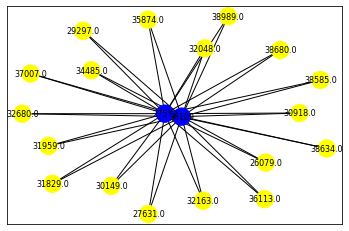

In [159]:
#fig = plt.figure(3, figsize=(500,500))
nx.draw_networkx(G, node_color=colors, font_size=8)

In [160]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 20
Number of edges: 36
Average degree:   3.6000


### Issue Contributor Graph

In [161]:
df_issue = df_all_subset.groupby(['Repo ID', 'Issue Authors']).size().unstack(fill_value=0)
df_issue.head()

Empty DataFrame
Columns: []
Index: []

In [162]:
df_issue.columns

Float64Index([], dtype='float64', name='Issue Authors')

In [163]:
df_issue = df_issue.reset_index()

In [164]:
df_issue.head()

Empty DataFrame
Columns: [Repo ID]
Index: []

In [165]:
df_melted_issue = df_issue.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [166]:
df_melted_issue.head()

Empty DataFrame
Columns: [Repo ID, Contributor, number]
Index: []

In [167]:
Repo_id = df_melted_issue['Repo ID'].to_list()
len(Repo_id)

0

In [168]:
contributor_id = df_melted_issue['Contributor'].to_list()
len(contributor_id)

0

In [169]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [170]:
nodes = G.nodes()
nodes

NodeView(())

In [171]:
nodes = list(nodes)
len(nodes)

0

In [172]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

In [173]:
fig = plt.figure(3, figsize=(500,500))
nx.draw_networkx(G, node_color=colors, font_size=8)

In [174]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 0
Number of edges: 0



### PR Contributor Graph

In [175]:
df_pr = df_all_subset.groupby(['Repo ID', 'PR Creators']).size().unstack(fill_value=0)
df_pr.head()

PR Creators  25650.0  27010.0  30165.0  40325.0  40326.0  40327.0  40328.0  \
Repo ID                                                                      
36109         497280    49440    49920    98880    49486    49920    49920   

PR Creators  40329.0  40330.0  40331.0  
Repo ID                                 
36109          49920    49920    49920

In [176]:
df_pr = df_pr.reset_index()

In [177]:
df_melted_pr = df_pr.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [178]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [179]:
nodes = G.nodes()

In [180]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

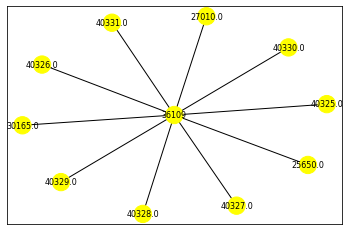

In [181]:
nx.draw_networkx(G, node_color=colors, font_size=8)

### PR Reviewers Graph

In [182]:
df_prr

PR Reviewers  Repo ID  27041.0  27211.0  27344.0  27821.0  29714.0  30475.0  \
0               36109       93       93       93       93       93       93   

PR Reviewers  31107.0  31197.0  36688.0  ...  43325.0  43326.0  43327.0  \
0                  93       93       93  ...       92       92       92   

PR Reviewers  43328.0  43329.0  43330.0  43331.0  43332.0  43333.0  43335.0  
0                  92       92       92       92       92       92       92  

[1 rows x 395 columns]

In [183]:
df_prr = df_all_subset.groupby(['Repo ID', 'PR Reviewers']).size().unstack(fill_value=0)
df_prr.head()

PR Reviewers  27041.0  27211.0  27344.0  27821.0  29714.0  30475.0  31107.0  \
Repo ID                                                                       
36109            2072     2072     2072     2072     2073     2073     2072   

PR Reviewers  31197.0  36688.0  37958.0  ...  43325.0  43326.0  43327.0  \
Repo ID                                  ...                              
36109            2072     2072     2072  ...     2072     2072     2072   

PR Reviewers  43328.0  43329.0  43330.0  43331.0  43332.0  43333.0  43335.0  
Repo ID                                                                      
36109            2072     2072     2072     2072     2072     2072     2072  

[1 rows x 394 columns]

In [184]:
df_prr = df_prr.reset_index()

In [185]:
df_melted_prr = df_prr.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [186]:
G = nx.from_pandas_edgelist(df_melted_prr, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [187]:
nodes = G.nodes()

In [188]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

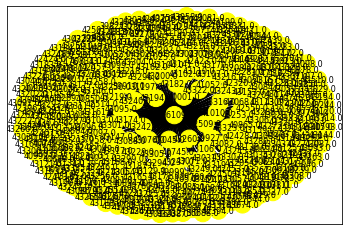

In [189]:
nx.draw_networkx(G, node_color=colors, font_size=8)

## Nodes as projects edges as contributors

In [190]:
df_melted_commit.head()

Repo ID Contributor  number
0    27572     26079.0       1
1    36109     26079.0       0
2    27572     27631.0       1
3    36109     27631.0       0
4    27572     29297.0       1

In [191]:
repos = df_melted_commit['Repo ID']
contributors = df_melted_commit['Contributor']

In [192]:
G = nx.Graph()

In [193]:
G.add_edge(1, 2, color='red', weight=100, size=300)

In [194]:
print(G[1][2]['size'])
300
print(G.edges[1, 2]['color'])

300
red


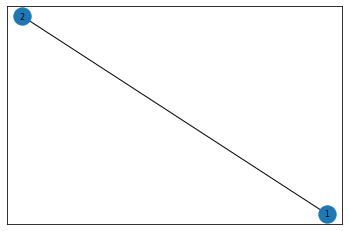

In [195]:
nx.draw_networkx(G, font_size=8)

In [196]:
import networkx as nx
import pandas as pd

data = {'source':["A", "A", "B", "B", "C", "F"],
        'destination':["B", "C", "C", "D", "D", "B"],
        'weight':[0.5, 0.2, 0.1, 0.1, 100, 1]}

df = pd.DataFrame(data)

g = nx.Graph()

weighted_edges = list(zip(*[df[col] for col in df]))

g.add_weighted_edges_from(weighted_edges)

In [197]:
list(zip(*[df[col] for col in df]))

[('A', 'B', 0.5),
 ('A', 'C', 0.2),
 ('B', 'C', 0.1),
 ('B', 'D', 0.1),
 ('C', 'D', 100.0),
 ('F', 'B', 1.0)]

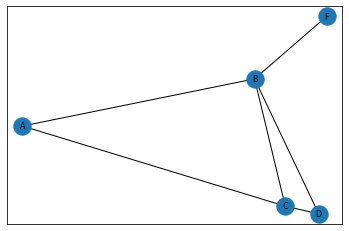

In [198]:
nx.draw_networkx(g, font_size=8)

In [199]:
df_melted_commit.head(100)

Repo ID Contributor  number
0     27572     26079.0       1
1     36109     26079.0       0
2     27572     27631.0       1
3     36109     27631.0       0
4     27572     29297.0       1
5     36109     29297.0       0
6     27572     30149.0      17
7     36109     30149.0       0
8     27572     30918.0    3325
9     36109     30918.0  399406
10    27572     31829.0       1
11    36109     31829.0       0
12    27572     31959.0       1
13    36109     31959.0       0
14    27572     32048.0    1911
15    36109     32048.0  595200
16    27572     32163.0       1
17    36109     32163.0       0
18    27572     32680.0       1
19    36109     32680.0       0
20    27572     34485.0       1
21    36109     34485.0       0
22    27572     35874.0     115
23    36109     35874.0       0
24    27572     36113.0       1
25    36109     36113.0       0
26    27572     37007.0       1
27    36109     37007.0       0
28    27572     38585.0       1
29    36109     38585.0       0
30    27572     38634.0       1
31    36109     38634.0       0
32    27572     38680.0      13
33    36109     38680.0       0
34    27572     38989.0       1
35    36109     38989.0       0

repo 1, repo 2, total contributions by common contributors  
repo 1, repo 4, total contributions by common contributors  
repo 2, repo 4, total contributions by common contributors  

27572, 36109, 45124+3325+1+1+1+9+10  
27572, 36108, 15  
  
contributor1: [(repo_id1, number1), (repo_id2, number2), ...]  
contributor2: [(repo_id1, number1), (repo_id2, number2), ...]  
  
contributor1: [((repo_id1, repo_id2), number1+number2), ((repo_id1, repo_id3), number1+number3), ...]  
  

In [200]:
contributorGraph = {}
for i, row in df_melted_commit.iterrows():
    if row['Contributor'] not in contributorGraph:
        contributorGraph[row['Contributor']] = []
    if(row['number'] > 0):
        contributorGraph[row['Contributor']].append((row['Repo ID'], row['number']))
print(contributorGraph)

{26079.0: [(27572, 1)], 27631.0: [(27572, 1)], 29297.0: [(27572, 1)], 30149.0: [(27572, 17)], 30918.0: [(27572, 3325), (36109, 399406)], 31829.0: [(27572, 1)], 31959.0: [(27572, 1)], 32048.0: [(27572, 1911), (36109, 595200)], 32163.0: [(27572, 1)], 32680.0: [(27572, 1)], 34485.0: [(27572, 1)], 35874.0: [(27572, 115)], 36113.0: [(27572, 1)], 37007.0: [(27572, 1)], 38585.0: [(27572, 1)], 38634.0: [(27572, 1)], 38680.0: [(27572, 13)], 38989.0: [(27572, 1)]}


In [207]:
import collections
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        print(commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])])
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
#     contributorGraph[key] = commonRepoContributionsByContributor
print(commonRepoContributionsByContributor)

0
402731
defaultdict(<class 'int'>, {(27572, 36109): 999842})


In [208]:
commonRepoContributionsByContributor

defaultdict(int, {(27572, 36109): 999842})

In [230]:
res = ()
for key in commonRepoContributionsByContributor:
    res = tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],)

In [233]:
[res]

[('27572', '36109', 999842)]

In [234]:
g = nx.Graph()

g.add_weighted_edges_from([res])

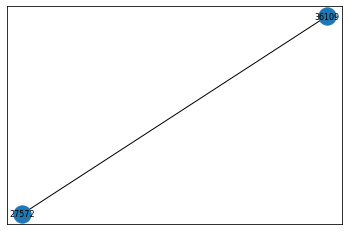

In [235]:
nx.draw_networkx(g, font_size=8)